In [2]:
# General setup
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import site

import time
# from numba import jit

from astropy.cosmology import Planck15


import pickle
import random 
import math
import os
from scipy.stats import chi2
import h5py 

In [3]:
def ionized_fraction_rind(redshift, threshold, realization, hdf5_path, min_z): 
    y0vec_arcmin, z0vec_arcmin, extent, envelope, maps = read_hdf5(min_z, 9.85, realization, hdf5_path)
    mpc_per_arcmin = Planck15.kpc_proper_per_arcmin(redshift).value * 1/1000 
    
    map_key = 'BPASS_Bin_Rec'
    map = (maps['z_{:.3f}'.format(redshift)][map_key][:])
    
    #converting arcmin to mpc 
    y0vec = y0vec_arcmin * mpc_per_arcmin
    z0vec = z0vec_arcmin * mpc_per_arcmin
    
    #removing a 1pMpc rind and finding values that are 1+/- the min/max
    #if we want to find the border where 1pMpc is, then we want to find the where the minimum value is and add 1
    #this index is where the 1pMpc border is 
    rindy_min = np.where(y0vec <= min(y0vec) + 1)[0][-1] 
    rindy_max = np.where(y0vec >= max(y0vec) - 1)[0][0]
    rindz_min = np.where(z0vec <= min(z0vec) + 1)[0][-1]
    rindz_max = np.where(z0vec >= max(z0vec) - 1)[0][0]
    
    #the length differs between redshift maps 
    ylength = rindy_max - rindy_min 
    zlength = rindz_max - rindz_min 
    area = ylength * zlength
    
    count = 0
    for i in range(len(map)): 
        for j in range(len(map)): 
            if map[i][j] <= threshold and i >= rindy_min and i <= rindy_max and j <= rindz_max and j >= rindz_min: 
                count += 1
    count = count / area
    return count

def read_hdf5(minz, maxz, realization, path): 
    fname = f'sam_bubble_maps.{realization}.{minz:.3f}_z_{maxz:.3f}.h5'
    # out_path = f'/Users/slkumar/Downloads/SangeetaBubbles/{realization}/' 
    out_path = path
    maps = h5py.File('{}/{}'.format(out_path, fname), 'r')
    
    envelope = maps['Header'].attrs['z_env']
    nstep = maps['Header'].attrs['n_step']
    redshift = maps['Header'].attrs['redshifts']
    
    y0vec_arcmin = maps['Header'].attrs['y0vec_arcmin']
    dy_arcmin = y0vec_arcmin[1] - y0vec_arcmin[0]
    z0vec_arcmin = maps['Header'].attrs['z0vec_arcmin']
    dz_arcmin = z0vec_arcmin[1] - z0vec_arcmin[0]

    extent=np.array([y0vec_arcmin[0] - dy_arcmin / 2, 
                 y0vec_arcmin[-1] + dy_arcmin / 2, 
                 z0vec_arcmin[0] - dz_arcmin / 2, 
                 z0vec_arcmin[-1] - dz_arcmin / 2])

    return y0vec_arcmin, z0vec_arcmin, extent, envelope, maps
    
def neutral_fraction(redshift, threshold, realization, path, minz): 
    y0vec_arcmin, z0vec_arcmin, extent, envelope, maps = read_hdf5(minz, 9.85, realization, path)
    map_key = 'BPASS_Bin_Rec'
    map = (maps['z_{:.3f}'.format(redshift)][map_key][:])
    count = 0
    for i in range(len(map)): 
        for j in range(len(map)): 
            if map[i][j] >= threshold: 
                count += 1
    count = count / (300*300)
    return count

In [4]:
realization_list = ['wide.0', 'wide.1', 'wide.2', 'wide.3', 'wide.4']
z_list = np.arange(5.50, 9.875, step = 0.025)
cone_fesc05_rind = {'wide.0':[], 'wide.1':[], 'wide.2':[], 'wide.3':[], 'wide.4':[]}
cone_fesc08_rind = {'wide.0':[], 'wide.1':[], 'wide.2':[], 'wide.3':[], 'wide.4':[]}

for realization in realization_list:
    neutral_fraction05 = []
    neutral_fraction08 = []
    for z in z_list:
        hdf5path = f'/Users/slkumar/Downloads/SangeetaBubbles/{realization}'
        neutral_fraction05.append(ionized_fraction_rind(z, 0.5, realization, hdf5_path = hdf5path, min_z = 5.50))
        neutral_fraction08.append(ionized_fraction_rind(z, 0.8, realization, hdf5_path = hdf5path, min_z = 5.50))
    cone_fesc05_rind[realization] = np.array(neutral_fraction05)
    cone_fesc08_rind[realization] = np.array(neutral_fraction08)

In [6]:
realization_list = ['wide.0', 'wide.1', 'wide.2', 'wide.3', 'wide.4']
z_list = np.arange(5.50, 9.875, step = 0.025)
cone_fesc05 = {'wide.0':[], 'wide.1':[], 'wide.2':[], 'wide.3':[], 'wide.4':[]}
cone_fesc08 = {'wide.0':[], 'wide.1':[], 'wide.2':[], 'wide.3':[], 'wide.4':[]}

for realization in realization_list:
    neutral_fraction05 = []
    neutral_fraction08 = []
    for z in z_list:
        hdf5path = f'/Users/slkumar/Downloads/SangeetaBubbles/{realization}'
        neutral_fraction05.append(neutral_fraction(z, 0.5, realization, path = hdf5path, minz = 5.50))
        neutral_fraction08.append(neutral_fraction(z, 0.8, realization, path = hdf5path, minz = 5.50))
    cone_fesc05[realization] = 1-np.array(neutral_fraction05)
    cone_fesc08[realization] = 1-np.array(neutral_fraction08)

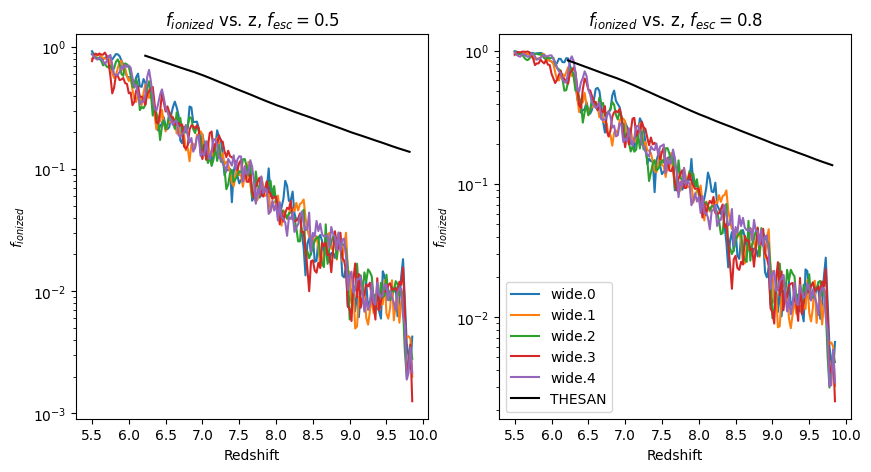

In [12]:
thesan = pd.read_csv('/Users/slkumar/Downloads/Default Dataset (2).csv', header = None)
thesan_z = thesan[0]
thesan_ionized = thesan[1]
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5))
for i, realization in zip(cone_fesc05, realization_list):
    ax[0].plot(z_list, cone_fesc05[i], label = realization)
    ax[1].plot(z_list, cone_fesc08[i], label = realization)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_xlabel('Redshift')
ax[0].set_ylabel('$f_{ionized}$')
ax[1].set_xlabel('Redshift')
ax[1].set_ylabel('$f_{ionized}$')
ax[0].set_title('$f_{ionized}$ vs. z, $f_{esc} = 0.5$')
ax[1].set_title('$f_{ionized}$ vs. z, $f_{esc} = 0.8$')
ax[0].plot(thesan_z, thesan_ionized, label = 'THESAN', color = 'black')
ax[1].plot(thesan_z, thesan_ionized, label = 'THESAN', color = 'black')


plt.legend()
ax[0].set_xticks(np.arange(5.50, 10.5, step = 0.5))
ax[1].set_xticks(np.arange(5.50, 10.5, step = 0.5))

plt.show()
fig.savefig('/Users/slkumar/Downloads/fionized0508.png')

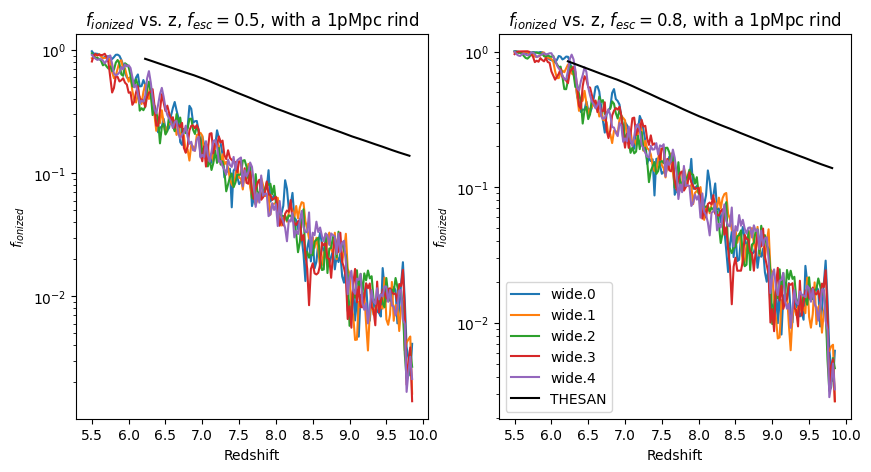

In [13]:
thesan = pd.read_csv('/Users/slkumar/Downloads/Default Dataset (2).csv', header = None)
thesan_z = thesan[0]
thesan_ionized = thesan[1]
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5))
for i, realization in zip(cone_fesc05, realization_list):
    ax[0].plot(z_list, cone_fesc05_rind[i], label = realization)
    ax[1].plot(z_list, cone_fesc08_rind[i], label = realization)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_xlabel('Redshift')
ax[0].set_ylabel('$f_{ionized}$')
ax[1].set_xlabel('Redshift')
ax[1].set_ylabel('$f_{ionized}$')
ax[0].set_title('$f_{ionized}$ vs. z, $f_{esc} = 0.5$, with a 1pMpc rind')
ax[1].set_title('$f_{ionized}$ vs. z, $f_{esc} = 0.8$, with a 1pMpc rind')
ax[0].plot(thesan_z, thesan_ionized, label = 'THESAN', color = 'black')
ax[1].plot(thesan_z, thesan_ionized, label = 'THESAN', color = 'black')
# ax[0].set_ylim(1e-9, 1)
# ax[1].set_ylim(1e-9, 1)

plt.legend()
ax[0].set_xticks(np.arange(5.50, 10.5, step = 0.5))
ax[1].set_xticks(np.arange(5.50, 10.5, step = 0.5))

plt.show()

In [9]:
def ratio_pre_post(file_path):
    neutral_df = pd.read_csv(file_path, header = 0)
    neutral_df = neutral_df.drop(columns=['Unnamed: 0']) #idk why this column appears 
    volume_frac = neutral_df['neutral fraction']
    
    pre_igm_index = np.arange(2, len(neutral_df.columns), step = 2)
    post_igm_index = np.arange(3, len(neutral_df.columns), step = 2)
    
    post_igm = neutral_df[neutral_df.columns[post_igm_index]]
    pre_igm = neutral_df[neutral_df.columns[pre_igm_index]]
    
    total_errors = np.array([])
    number_preigm = []
    number_postigm = []
    for i in range(len(pre_igm)): 
        #gets the row of the neutral fraction 
        # .iloc[2:] is for starting at luminosity bin 43
        # i = column 
        #print(post_igm.columns[i])
        no_pre_igm = neutral_df[neutral_df.columns[pre_igm_index]].iloc[2:][neutral_df.columns[pre_igm_index[i]]] 
        no_post_igm = neutral_df[neutral_df.columns[post_igm_index]].iloc[2:][neutral_df.columns[post_igm_index[i]]]
        #print(no_post_igm)
        no_pre_igm = np.array(no_pre_igm)
        no_post_igm = np.array(no_post_igm)
        
        number_preigm.append(np.nansum(no_pre_igm))
        number_postigm.append(np.nansum(no_post_igm))
        
        #errors    
        current_errors = prop_errors(np.nansum(no_post_igm), np.nansum(no_pre_igm))
        total_errors = np.append(total_errors, current_errors)
     #ratio, need to be array for division    
    ratio = np.array(number_postigm)/np.array(number_preigm)
    
    return ratio, volume_frac, total_errors

def create_errorbars(df, header = False): 
    point = []
    lower = []
    upper = []
    bins = []
    if header == True: 
        col_name = 'upper'
        bin_name = 'data'
    else: 
        col_name = 1
        bin_name = 0
    for i in np.arange(len(df), step = 3): 
        group_points = np.array(df[col_name].loc[i:i +2])
        point.append(group_points[1])
        lower.append(group_points[0])
        upper.append(group_points[2])
        bins.append(df[bin_name].loc[i])
    return bins, point, lower, upper 
def prop_errors(a, b): 
    #parameters a and b should be single digit numbers 
    #parameters a_err and b_err should be arrays 
    quant_b = np.sqrt(b) / b
    quant_a = np.sqrt(a) / a
    prop_err = (a/b)*np.sqrt(quant_a**2 + quant_b**2)
    prop_err = np.sum(prop_err)
    return prop_err


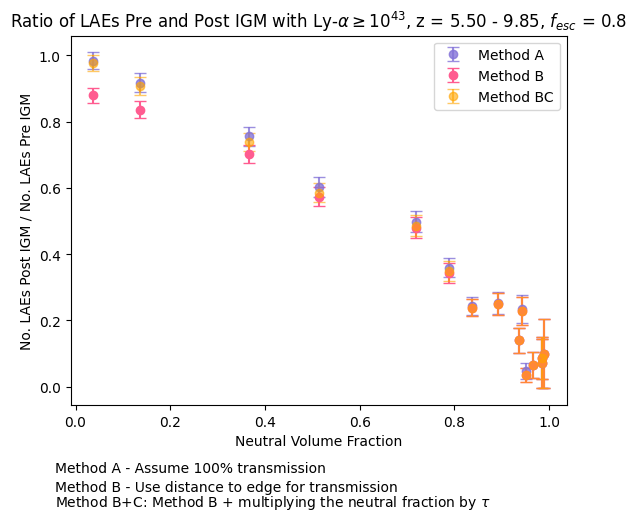

In [10]:
"""How it works:
This code generates a plot of netural fraction vs. the ratio between post and pre IGM numbers of LAE 
The neutral_df is created through an earlier piece of code 
neutral_df contains the number of LAEs per luminosity bin for each redshift range, 
the averaged neutral fraction for each redshift range, and the luminoisty bins
The goal of the plot is to showcase the ratio post/pre for LAEs above a given luminosity 
In order to do this we get the columns that correspond to pre and post IGM and add up the values corresponding to values greater than the 
luminosity threshold for each column 
This results in one value per column for post IGM and pre IGM which are added to arrays per iteration
For each sum we get errors which are added to an array at each iteration 
At the end of the for loop we get the ratio by dividing the pre and post IGM numbers arrays
At the end the number of neutral fractions should be the same as the length of the ratio array 
Think of neutral fraction analogous to redshift, the redshift range contains LAEs of all luminosities
"""

allwidecones = '/Users/slkumar/Downloads/AllMethods/AllWideCones'
ratioA, volume_fracA, totalerrorsA = ratio_pre_post(allwidecones +'/MethodA/NeutralFraction/NeutralFractionsMethodA.csv')
ratioB, volume_fracB, totalerrorsB = ratio_pre_post(allwidecones +'/MethodB/NeutralFraction/NeutralFractionsMethodB.csv')
ratioBC, volume_fracBC, totalerrorsBC = ratio_pre_post(allwidecones + '/MethodBC/NeutralFraction/NeutralFractionsMethodBC.csv')
fig = plt.figure()
plt.errorbar(volume_fracA, ratioA, yerr = totalerrorsA, fmt = 'o', capsize = 4, label  = 'Method A', color = '#8473d8', alpha = 0.8)
plt.errorbar(volume_fracB, ratioB, yerr = totalerrorsB, fmt = 'o', capsize = 4, label = 'Method B', color = '#ff5c90')
plt.errorbar(volume_fracBC, ratioBC, yerr = totalerrorsBC, fmt = 'o', capsize = 4, label  = 'Method BC', color = 'orange', alpha = 0.6)

txt = 'Method A - Assume 100% transmission'
txt2 = 'Method B - Use distance to edge for transmission'
txt3 = 'Method B+C: Method B + multiplying the neutral fraction by $\\tau$'
plt.figtext(0.1, -0.03, txt)
plt.figtext(0.1, -0.07, txt2)
plt.figtext(0.1, -0.1, txt3, wrap = True)
plt.legend()
plt.ylabel('No. LAEs Post IGM / No. LAEs Pre IGM')
plt.xlabel("Neutral Volume Fraction")
plt.title(r'Ratio of LAEs Pre and Post IGM with Ly-$\alpha \geq 10^{43}$, z = 5.50 - 9.85, $f_{esc}$ = 0.8')
plt.show()
fig.savefig(allwidecones + '/prepost.png', bbox_inches = 'tight')

/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_92023/3149326766.py:59: RuntimeWarning: invalid value encountered in scalar divide
  quant_a = np.sqrt(a) / a
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_92023/3149326766.py:59: RuntimeWarning: invalid value encountered in scalar divide
  quant_a = np.sqrt(a) / a
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_92023/3149326766.py:59: RuntimeWarning: invalid value encountered in scalar divide
  quant_a = np.sqrt(a) / a
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_92023/3149326766.py:59: RuntimeWarning: invalid value encountered in scalar divide
  quant_a = np.sqrt(a) / a
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_92023/3149326766.py:59: RuntimeWarning: invalid value encountered in scalar divide
  quant_a = np.sqrt(a) / a


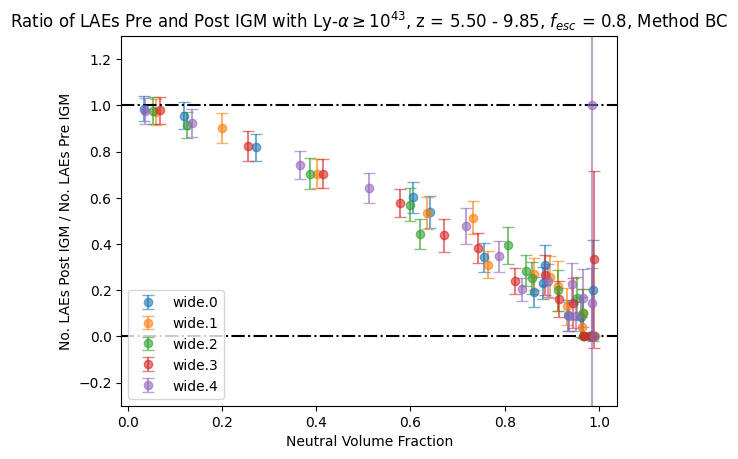

In [11]:
fig = plt.figure()
for realization in realization_list:
    path = f'/Users/slkumar/Downloads/AllMethods/{realization}/MethodBC/NeutralFraction/NeutralFractionsMethodBC.csv'
    ratioBC, volume_fracBC, totalerrorsBC = ratio_pre_post(path)
    plt.errorbar(volume_fracBC, ratioBC, yerr = totalerrorsBC, fmt = 'o', capsize = 4, label  = realization, alpha = 0.6)
    
    
plt.legend(loc = 'lower left')
plt.axhline(1, c = 'black', linestyle = '-.')
plt.axhline(0, c = 'black', linestyle = '-.')
plt.ylim(-0.3, 1.3)
plt.ylabel('No. LAEs Post IGM / No. LAEs Pre IGM')
plt.xlabel("Neutral Volume Fraction")
plt.title(r'Ratio of LAEs Pre and Post IGM with Ly-$\alpha \geq 10^{43}$, z = 5.50 - 9.85, $f_{esc}$ = 0.8, Method BC')
plt.show()
fig.savefig('/Users/slkumar/Downloads/prepostratio.png', bbox_inches = 'tight')

In [7]:
corr_cone_fesc05 = {'wide.0':[], 'wide.1':[], 'wide.2':[], 'wide.3':[], 'wide.4':[]}
corr_cone_fesc08 = {'wide.0':[], 'wide.1':[], 'wide.2':[], 'wide.3':[], 'wide.4':[]}
realization_list = ['wide.0', 'wide.1', 'wide.2', 'wide.3', 'wide.4']
correction_table = pd.read_csv('/Users/slkumar/Downloads/Correction_Table.csv', header = 0)
z_list = np.arange(5.50, 9.875, step = 0.025)
for realization in realization_list:
    corr_neutral_fraction05 = []
    corr_neutral_fraction08 = []
    for z in z_list:
        #need to find the value that is closest to the current redshift to multiply by the correction factor 
        diff = np.abs(correction_table['Redshift'] - z)
        value_to_find = min(np.abs(correction_table['Redshift'] - z))
        closest_z = np.where(diff == value_to_find)[0][0]
        correction_factor = correction_table['correction_factor'][closest_z]
        hdf5path = f'/Users/slkumar/Downloads/SangeetaBubbles/{realization}'
        #dividing by the correction factor 
        corr_neutral_fraction05.append(ionized_fraction_rind(z, 0.5, realization, hdf5_path = hdf5path, min_z = 5.50) / correction_factor)
        corr_neutral_fraction08.append(ionized_fraction_rind(z, 0.8, realization, hdf5_path = hdf5path, min_z = 5.50) / correction_factor)

    corr_cone_fesc05[realization] = np.array(corr_neutral_fraction05)
    corr_cone_fesc08[realization] = np.array(corr_neutral_fraction08)

KeyError: 0

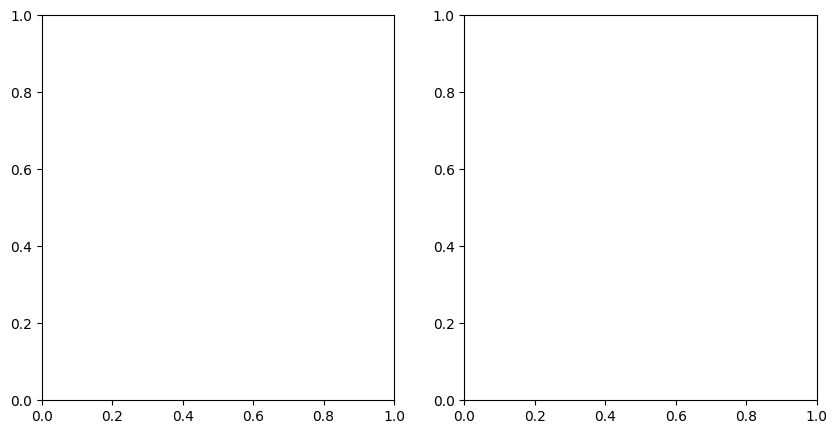

In [18]:
thesan = pd.read_csv('/Users/slkumar/Downloads/Default Dataset (2).csv', header = None)
thesan_z = thesan[0]
thesan_ionized = thesan[1]
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5))
ax[0].plot(z_list, corr_cone_fesc05[0], label = realization)
ax[1].plot(z_list, corr_cone_fesc08[0], label = realization)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_xlabel('Redshift')
ax[0].set_ylabel('$f_{ionized}$')
ax[1].set_xlabel('Redshift')
ax[1].set_ylabel('$f_{ionized}$')
ax[0].set_title('$f_{ionized}$ vs. z, $f_{esc} = 0.5$, with a 1pMpc rind')
ax[1].set_title('$f_{ionized}$ vs. z, $f_{esc} = 0.8$, with a 1pMpc rind')
ax[0].plot(thesan_z, thesan_ionized, label = 'THESAN', color = 'black')
ax[1].plot(thesan_z, thesan_ionized, label = 'THESAN', color = 'black')
# ax[0].set_ylim(1e-9, 1)
# ax[1].set_ylim(1e-9, 1)

plt.legend()
ax[0].set_xticks(np.arange(5.50, 10.5, step = 0.5))
ax[1].set_xticks(np.arange(5.50, 10.5, step = 0.5))

plt.show()

In [8]:
comp_wide0 = {'original':cone_fesc05_rind.get('wide.0'), 'correction_factor':corr_cone_fesc08.get('wide.0') , 'corrected':[]}

In [9]:
new_arr = []
realization = 'wide.0'
hdf5_path = '/Users/slkumar/Downloads/CorrectionFactorMaps/wide.0/pklFiles'
for z in np.arange(5.50,9.86, step = 0.025): 
    new_arr.append(ionized_fraction_rind(z, 0.8, realization, hdf5_path, 5.50))
comp_wide0['corrected'] = new_arr

In [5]:
wide1 = []
realization = 'wide.1'
hdf5_path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/pklFiles'
for z in np.arange(5.50,9.86, step = 0.025): 
    wide1.append(ionized_fraction_rind(z, 0.8, realization, hdf5_path, 5.50))


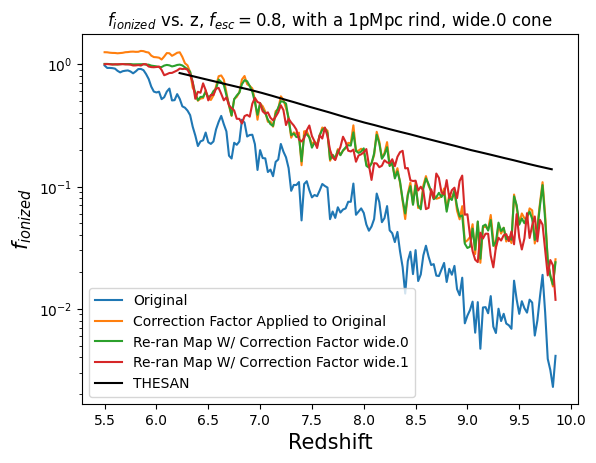

In [11]:
thesan = pd.read_csv('/Users/slkumar/Downloads/Default Dataset (2).csv', header = None)
thesan_z = thesan[0]
thesan_ionized = thesan[1]
plt.figure()
plt.plot(z_list, comp_wide0['original'], label = 'Original')
plt.plot(z_list, comp_wide0['correction_factor'], label = 'Correction Factor Applied to Original')
plt.plot(np.arange(5.50, 9.86, step = 0.025), comp_wide0['corrected'], label = 'Re-ran Map W/ Correction Factor wide.0')
plt.plot(np.arange(5.50, 9.86, step = 0.025), wide1, label = 'Re-ran Map W/ Correction Factor wide.1')


plt.yscale('log')

plt.xlabel('Redshift', size = 15)
plt.ylabel('$f_{ionized}$', size = 15)
plt.title('$f_{ionized}$ vs. z, $f_{esc} = 0.8$, with a 1pMpc rind, wide.0 cone')
plt.plot(thesan_z, thesan_ionized, label = 'THESAN', color = 'black')

plt.legend(loc = 'lower left')
plt.xticks(np.arange(5.50, 10.5, step = 0.5))

plt.show()

In [40]:
min_z = 9.0
realization = 'wide.0'
hdf5_path = hdf5_path
redshift = 9.0
threshold = 0.8
y0vec_arcmin, z0vec_arcmin, extent, envelope, maps = read_hdf5(min_z, 9.85, realization, hdf5_path)
mpc_per_arcmin = Planck15.kpc_proper_per_arcmin(redshift).value * 1/1000 

map_key = 'BPASS_Bin_Rec'
map = (maps['z_{:.3f}'.format(redshift)][map_key][:])

#converting arcmin to mpc 
y0vec = y0vec_arcmin * mpc_per_arcmin
z0vec = z0vec_arcmin * mpc_per_arcmin

#removing a 1pMpc rind and finding values that are 1+/- the min/max
#if we want to find the border where 1pMpc is, then we want to find the where the minimum value is and add 1
#this index is where the 1pMpc border is 
rindy_min = np.where(y0vec <= min(y0vec) + 1)[0][-1] 
rindy_max = np.where(y0vec >= max(y0vec) - 1)[0][0]
rindz_min = np.where(z0vec <= min(z0vec) + 1)[0][-1]
rindz_max = np.where(z0vec >= max(z0vec) - 1)[0][0]

#the length differs between redshift maps 
ylength = rindy_max - rindy_min 
zlength = rindz_max - rindz_min 
area = ylength * zlength

count = 0
for i in range(len(map)): 
    for j in range(len(map)): 
        if map[i][j] <= threshold and i >= rindy_min and i <= rindy_max and j <= rindz_max and j >= rindz_min: 
            count += 1
count = count / area

In [41]:
count

np.float64(0.005209917355371901)